# 环境

In [1]:
!uv add matplotlib
!uv add numpy
!uv add scipy
!uv add silero-vad
!uv add torch
!uv add tqdm

Resolved 145 packages in 0.80ms
Audited 116 packages in 0.05ms
Resolved 145 packages in 0.81ms
Audited 116 packages in 0.07ms
Resolved 145 packages in 0.87ms
Audited 116 packages in 0.11ms
Resolved 145 packages in 0.75ms
Audited 116 packages in 0.05ms
Resolved 145 packages in 0.74ms
Audited 116 packages in 0.06ms
Resolved 145 packages in 0.75ms
Audited 116 packages in 0.05ms


In [2]:
import os
import time

import matplotlib.pylab as plt
import numpy as np
from scipy.io import wavfile
from silero_vad import load_silero_vad, get_speech_timestamps, VADIterator
import torch
import tqdm

def calculate_db(chunk):
    rms = np.sqrt(np.mean(np.square(chunk)))
    return 20 * np.log10(rms + 1e-7) if rms > 0 else -np.inf

model = load_silero_vad(onnx=True)
prob_model = load_silero_vad(onnx=True)
SAMPLING_RATE = 16000
window_size_samples = 512 if SAMPLING_RATE == 16000 else 256

WAV_DIR_PATH = 'exp_data/untitled folder 2'
WAV_FILES = filter(lambda x: not x.startswith('.'), os.listdir(WAV_DIR_PATH))
WAV_PATHS = [os.path.join(WAV_DIR_PATH, e) for e in sorted(WAV_FILES)]
WAV_PATHS

['exp_data/untitled folder 2/2025-08-14_16-34-22-282_5s_80000samples.wav',
 'exp_data/untitled folder 2/2025-08-14_16-34-27-282_5s_80000samples.wav',
 'exp_data/untitled folder 2/2025-08-14_16-34-32-282_5s_80000samples.wav',
 'exp_data/untitled folder 2/2025-08-14_16-34-37-282_5s_80000samples.wav',
 'exp_data/untitled folder 2/2025-08-14_16-34-47-282_5s_80000samples.wav',
 'exp_data/untitled folder 2/2025-08-14_16-34-52-282_5s_80000samples.wav',
 'exp_data/untitled folder 2/2025-08-14_16-34-57-282_5s_80000samples.wav',
 'exp_data/untitled folder 2/2025-08-14_16-35-02-282_5s_80000samples.wav',
 'exp_data/untitled folder 2/2025-08-14_16-35-07-282_5s_80000samples.wav',
 'exp_data/untitled folder 2/2025-08-14_16-35-12-282_5s_80000samples.wav',
 'exp_data/untitled folder 2/2025-08-14_16-35-17-282_5s_80000samples.wav',
 'exp_data/untitled folder 2/2025-08-14_16-35-22-282_5s_80000samples.wav',
 'exp_data/untitled folder 2/2025-08-14_16-35-27-282_5s_80000samples.wav',
 'exp_data/untitled folde

# 流式VAD样例

In [3]:
# Provided by Alexander Veysov (https://github.com/snakers4/silero-vad/blob/master/examples/pyaudio-streaming/pyaudio-streaming-examples.ipynb)
def int2float(sound):
    abs_max = np.abs(sound).max()
    sound = sound.astype('float32')
    if abs_max > 0:
        sound *= 1/32768
    sound = sound.squeeze()  # depends on the use case
    return sound

vad_iterator = VADIterator(model, sampling_rate=SAMPLING_RATE)
vad_sec_iterator = VADIterator(model, sampling_rate=SAMPLING_RATE)
speech_probs = []
wavs = []
for path in WAV_PATHS:
    sample_rate, wav = wavfile.read(path)

    # 转换为float32并归一化
    if wav.dtype == np.int16:
        wav = wav.astype(np.float32) / 32768.0
    elif wav.dtype == np.float32:
        pass
    else:
        raise NotImplementedError('不被支持的数据类型')
    
    wav = torch.from_numpy(wav)
    # speech_timestamps = get_speech_timestamps(wav, model, sampling_rate=SAMPLING_RATE)
    # print(speech_timestamps)
    # print(wav.dtype, wav.shape)
    wavs.append(wav)
wav = torch.concat(wavs)

dbs = []
cnt = 0
# for i in tqdm.trange(0, len(wav), window_size_samples):
temp_ts = time.time()
time_gaps = []
for i in range(0, len(wav), window_size_samples):
    time_gaps.append(time.time()-temp_ts)
    temp_ts = time.time()
    chunk = wav[i: i+ window_size_samples]


    int_chunk = chunk.numpy() * 32767
    chunk_bytes = int_chunk.astype(np.int16).tobytes()
    db = calculate_db(int_chunk)
    dbs.append(db)

    if len(chunk) < window_size_samples:
        break
    speech_dict = vad_iterator(chunk)
    if speech_dict:
        print(speech_dict, sep=' ', end='')
        cnt += 1
        if cnt > 0 and cnt % 4 == 0:
            print()
            # vad_iterator.reset_states() # reset model states after each audio, but 和不重置的效果不一致
    speech_dict = vad_sec_iterator(chunk, return_seconds=True)
    if speech_dict:
        print(speech_dict, sep=' ', end='')
        cnt += 1
        if cnt > 0 and cnt % 4 == 0:
            print()
            # vad_iterator.reset_states() # reset model states after each audio, but 和不重置的效果不一致
        
    speech_prob = prob_model(chunk, SAMPLING_RATE).item()
    speech_probs.append(speech_prob)


{'start': 90656}{'start': 5.7}{'end': 98272}{'end': 6.1}
{'start': 133664}{'start': 8.4}{'end': 141792}{'end': 8.9}
{'start': 167968}{'start': 10.5}{'end': 180704}{'end': 11.3}
{'start': 205344}{'start': 12.8}{'end': 218080}{'end': 13.6}
{'start': 247328}{'start': 15.5}{'end': 15.9}{'end': 254944}
{'start': 1135648}{'start': 71.0}{'end': 1142240}{'end': 71.4}
{'start': 1201696}{'start': 75.1}{'end': 75.5}{'end': 1208288}
{'start': 1267232}{'start': 79.2}{'end': 1278432}{'end': 79.9}
{'start': 1301024}{'start': 81.3}{'end': 81.8}{'end': 1309152}
{'start': 1357856}{'start': 84.9}{'end': 85.6}{'end': 1369568}
{'start': 93.4}{'end': 93.5}{'start': 1681952}{'start': 105.1}
{'end': 1695200}{'end': 106.0}{'start': 1885728}{'start': 117.9}
{'end': 1888736}{'end': 118.0}{'start': 1890336}{'start': 118.1}
{'end': 1897952}{'end': 118.6}

## 人声概率在时间上分布

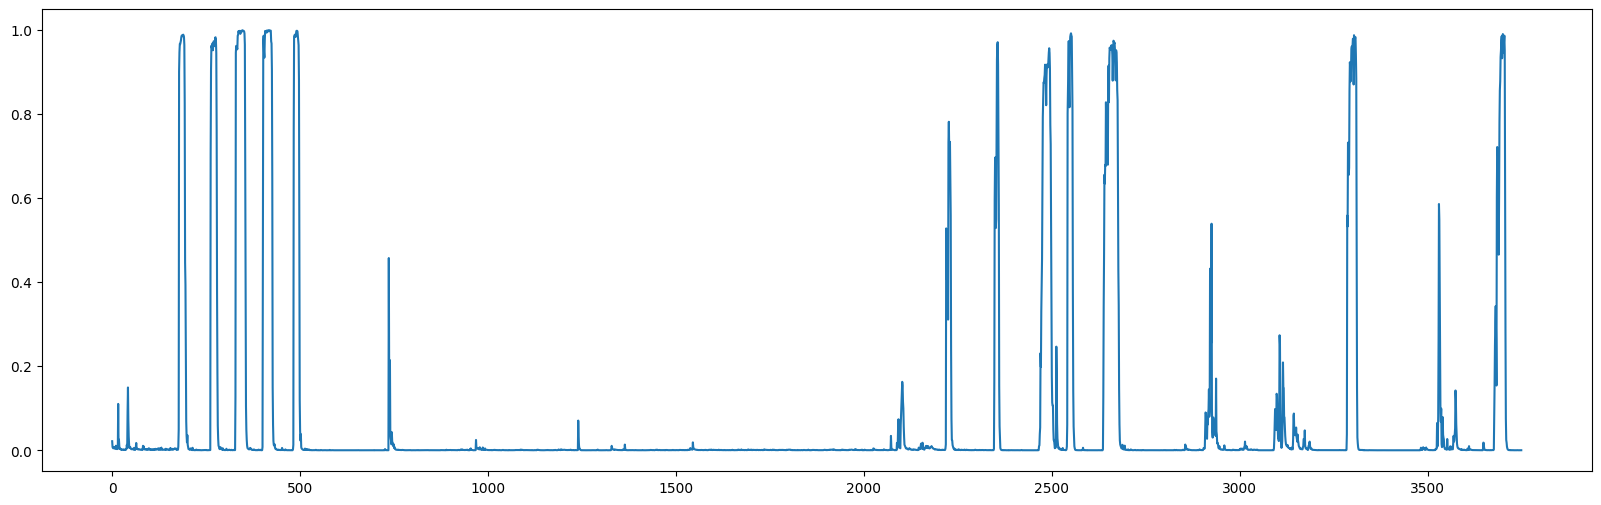

概率列表长度：3750
[0.021574079990386963, 0.007746577262878418, 0.005667835474014282, 0.00466996431350708, 0.0077596306800842285, 0.00555148720741272, 0.005490422248840332, 0.007813900709152222, 0.003114044666290283, 0.003492683172225952]
[0.00017687678337097168, 4.884600639343262e-05, 6.285309791564941e-05, 8.723139762878418e-05, 0.00014412403106689453, 4.89652156829834e-05, 8.216500282287598e-05, 4.2766332626342773e-05, 3.24249267578125e-05, 0.00013455748558044434]


In [4]:
plt.figure(figsize=(20,6))
plt.plot(speech_probs)
plt.show()
print(f'概率列表长度：{len(speech_probs)}')

print(speech_probs[:10])
print(speech_probs[-10:])

## 分贝数
看来啸叫噪音不一定比原语音分贝低

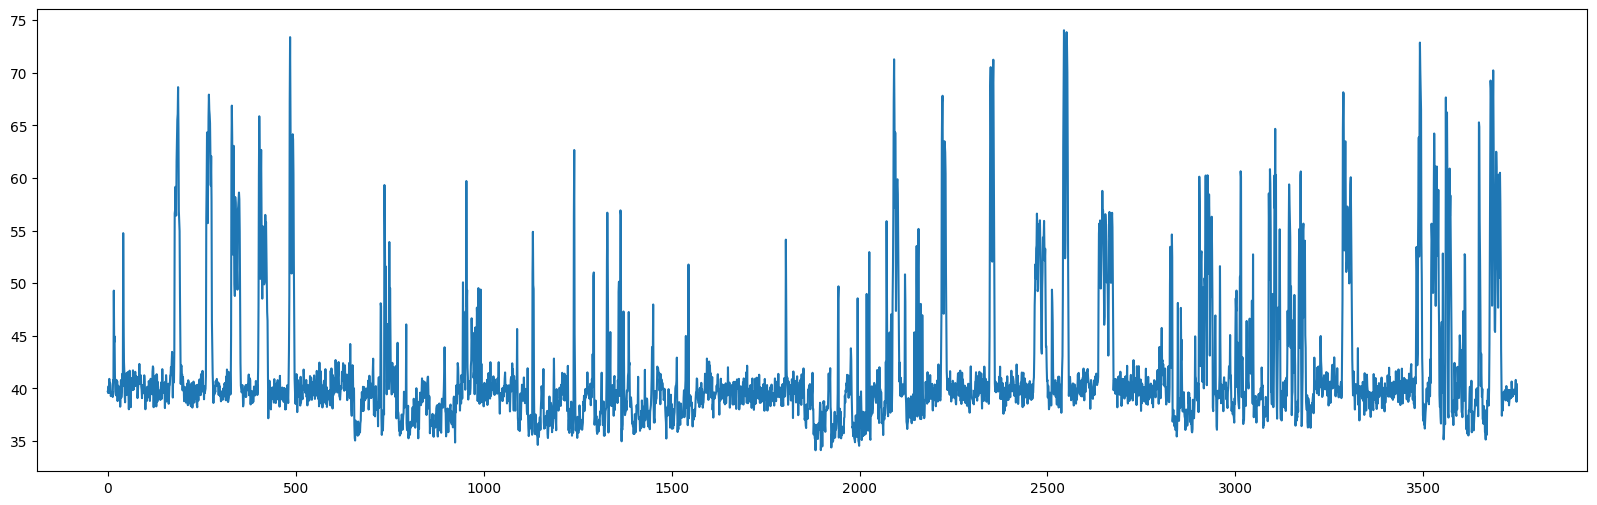

In [5]:
plt.figure(figsize=(20,6))
plt.plot(dbs)
plt.show()

## 延迟统计
< 1.2ms

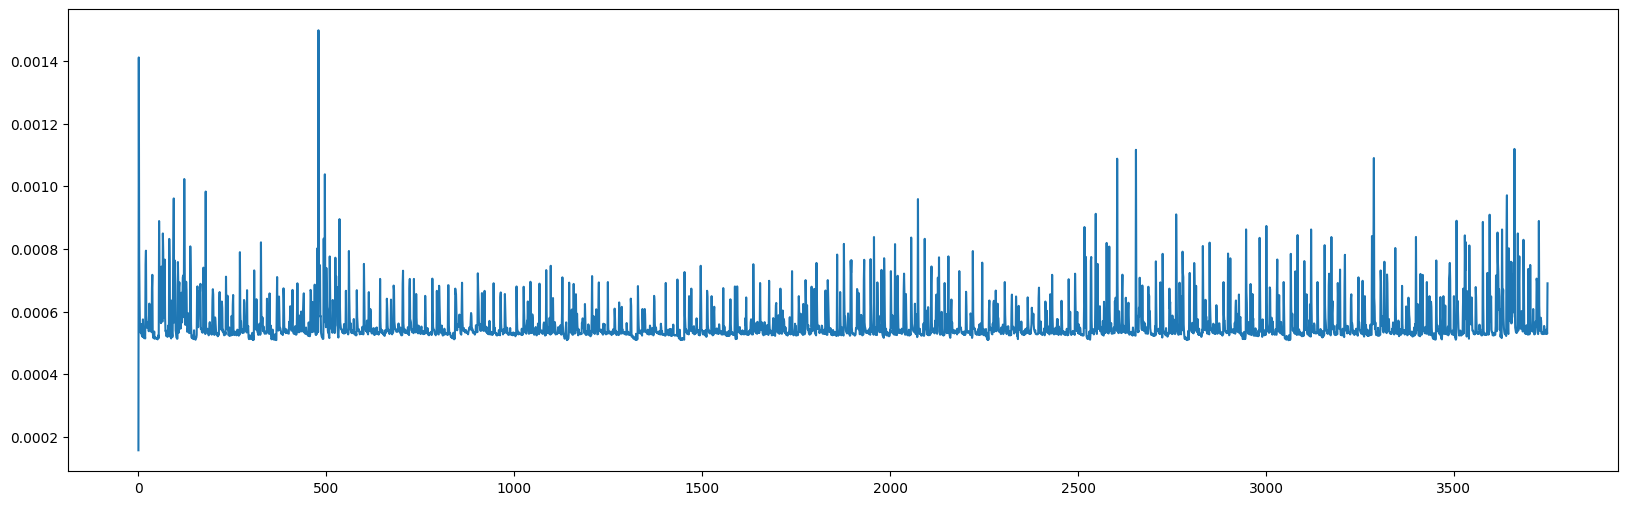

In [6]:
plt.figure(figsize=(20,6))
plt.plot(time_gaps)
plt.show()

In [7]:
sum(time_gaps)

2.101303815841675